In [1]:
# we use Pandas to work with the data as it makes working with categorical data very easy
import pandas as pd


In [2]:
from google.colab import files
uploaded=files.upload()

Saving Dataset.csv to Dataset.csv


In [3]:
import io

In [4]:
# this is a list of the column names in our dataset (as the file doesn't contain any headers)
names = (
    'age',
    'workclass', 
    'fnlwgt', 
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

# some fields are categorical and will require special treatment
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))
df = pd.read_csv(io.BytesIO(uploaded['Dataset.csv']), sep=", ", header=None, names=names, index_col=False, engine='python')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50k
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50k
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50k
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50k
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50k


In [5]:
for name in categorical:
    df[name] = df[name].astype('category')

In [6]:
#Implement a function that returns the spans (max-min for numerical columns, number of different values for categorical columns) of all columns for a partition of a dataframe.
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans
    

In [7]:
full_spans = get_spans(df, df.index)
full_spans


{'age': 73,
 'workclass': 9,
 'fnlwgt': 1476908,
 'education': 16,
 'education-num': 15,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital-gain': 99999,
 'capital-loss': 3770,
 'hours-per-week': 98,
 'native-country': 41,
 'income': 2}

In [8]:
#Implement a split function that takes a dataframe, partition and column and returns two partitions that split the given partition such that all rows with values of the column column below the median are in one partition and all rows with values above or equal to the median are in the other
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)
        

In [9]:
#Implement the partitioning algorithm discussed above, using a k-anonymous criterion for the partitions you create
def is_k_anonymous(df, partition, sensitive_column, k=2):
    """

    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k, K can be varied as k=2,4,6,8
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions
    

In [10]:
# we apply our partitioning method to two columns of our dataset, using "income" as the sensitive attribute
feature_columns = ['age', 'education-num']
sensitive_column = 'income'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [11]:
# we get the number of partitions that were created
len(finished_partitions)

450

In [12]:
import matplotlib.pylab as pl
import matplotlib.patches as patches


In [13]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [14]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])


In [15]:
# let's see how our rects look like
rects[:10]


[((17.0, 7.0), (18.0, 9.0)),
 ((18.0, 7.0), (21.0, 9.0)),
 ((23.0, 9.0), (25.0, 10.0)),
 ((28.0, 9.0), (30.0, 10.0)),
 ((21.0, 10.0), (22.0, 11.0)),
 ((22.0, 10.0), (24.0, 11.0)),
 ((37.0, 10.0), (38.0, 13.0)),
 ((41.0, 10.0), (43.0, 13.0)),
 ((46.0, 13.0), (48.0, 16.0)),
 ((19.0, 9.0), (20.0, 10.0))]

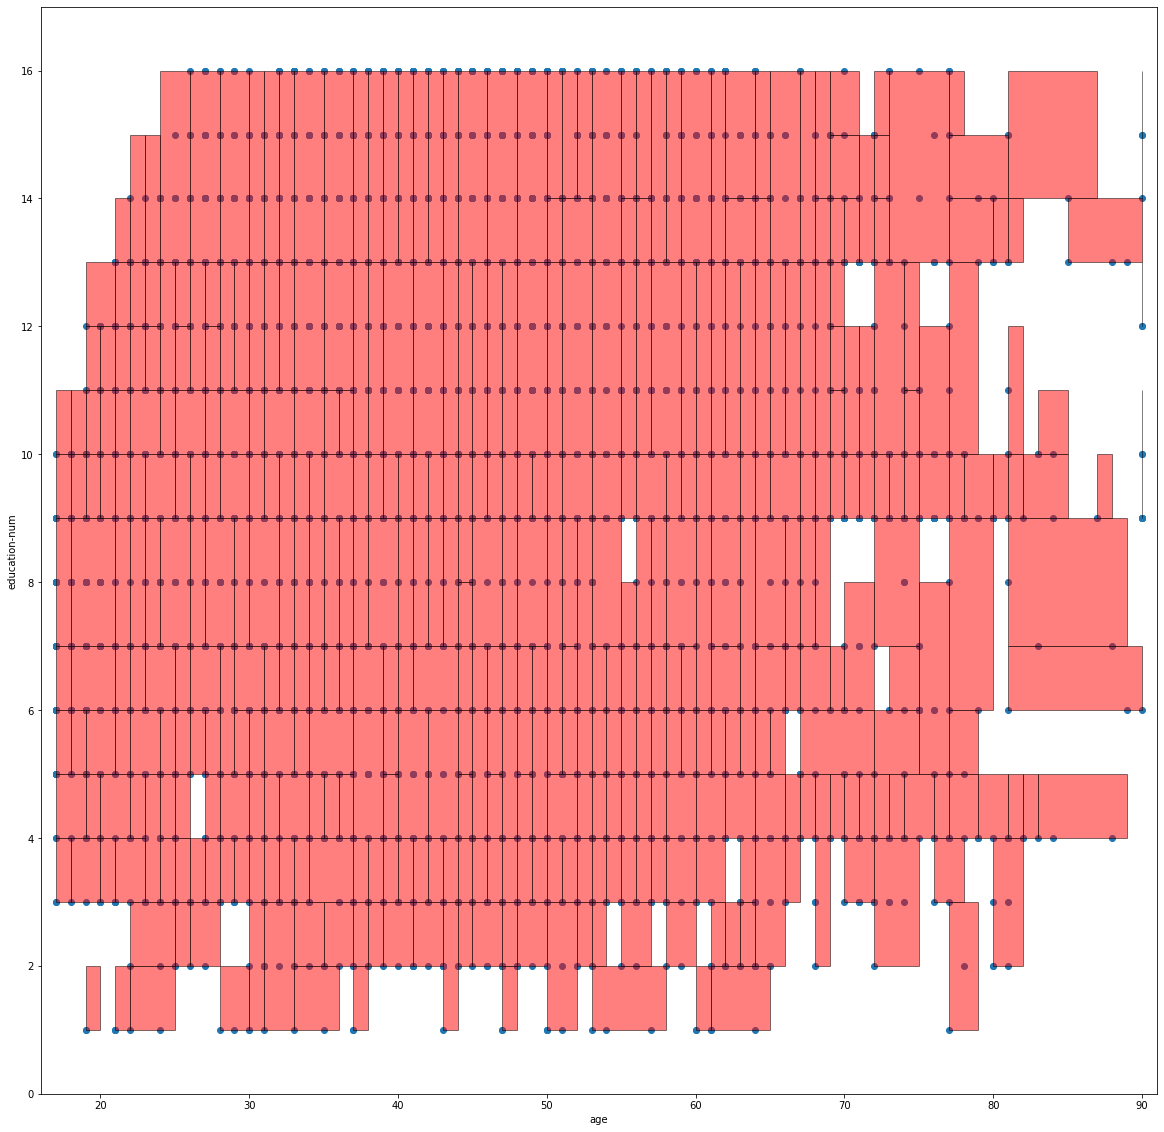

In [16]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [ ]:
#Generating an k-Anonymous Dataset

In [17]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]
    

In [38]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
      
  
        values = grouped_columns.apply(lambda x: x[0]).to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)
    

In [39]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...


In [40]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns+[sensitive_column])


,age,education-num,income,count
450,17.0,3.000000,<=50k,2
122,17.0,5.000000,<=50k,11
123,17.0,6.000000,<=50k,60
0,17.0,7.256410,<=50k,117
131,17.0,9.000000,<=50k,6
...,...,...,...,...
676,90.0,9.000000,>50k,2
693,90.0,10.000000,<=50k,2
694,90.0,12.000000,>50k,2
691,90.0,14.666667,<=50k,2


In [ ]:
#Implementing l-diversity

In [81]:
#Implement a validator function that returns True if a given partition contains at least l different values of the sensitive attribute, False otherwise

def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=6):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param                l: The minimum required diversity of sensitive attribute values in the partition, l can be varied where l=2,4,6,8
    """
    return diversity(df, partition, sensitive_column) >= l
    

In [82]:
# now let's apply this method to our data and see how the result changes
finished_l_diverse_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))
len(finished_l_diverse_partitions)

1

In [83]:
column_x, column_y = feature_columns[:2]
l_diverse_rects = get_partition_rects(df, finished_l_diverse_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])


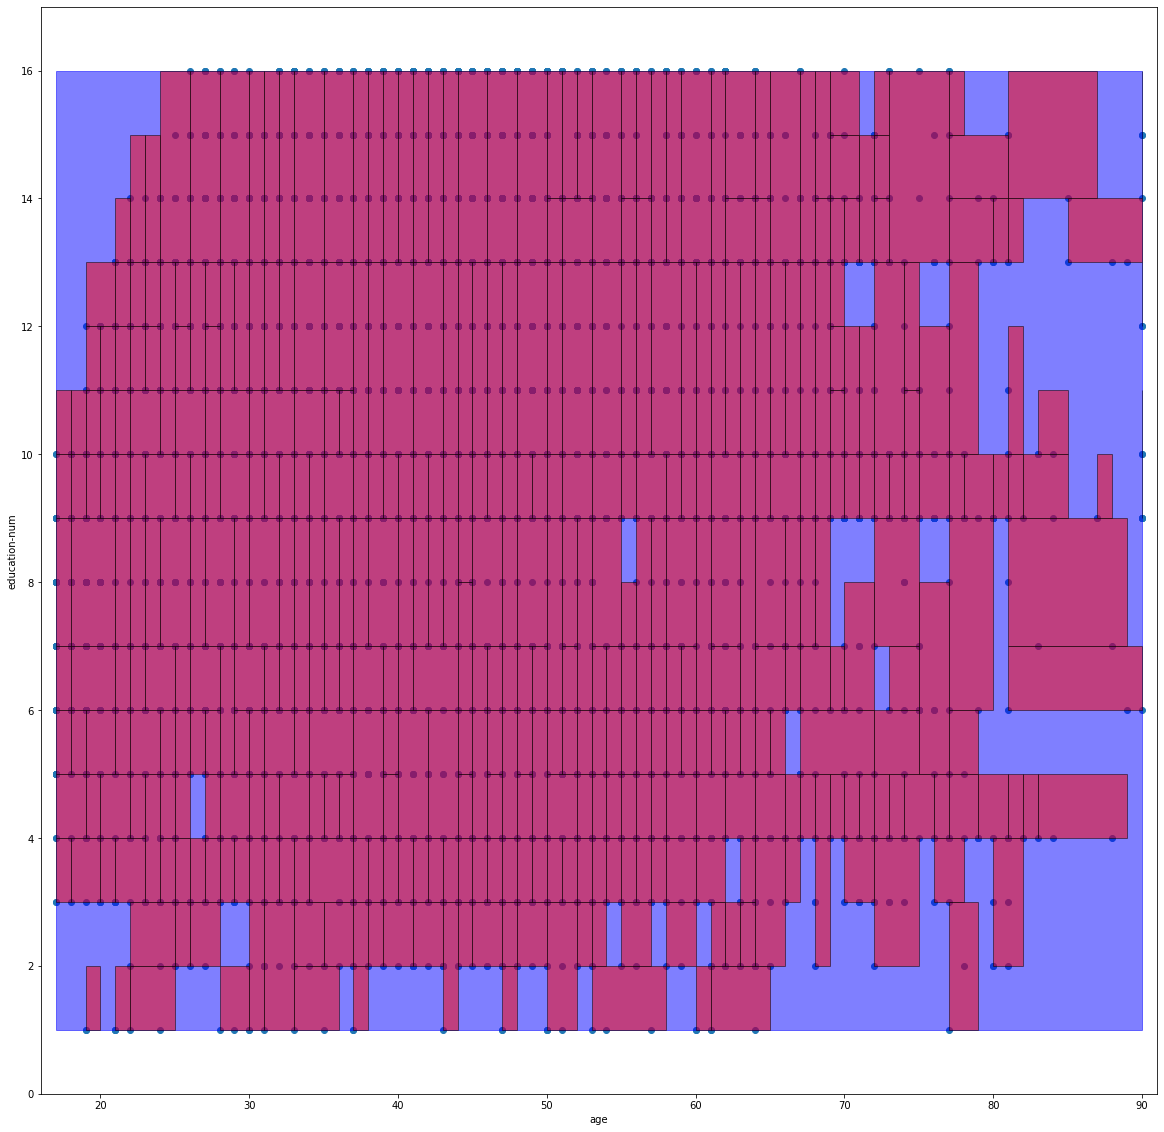

In [84]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, l_diverse_rects, column_x, column_y, edgecolor='b', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [85]:
# again we build an anonymized dataset from the l-diverse partitions
dfl = build_anonymized_dataset(df, finished_l_diverse_partitions, feature_columns, sensitive_column)

In [80]:
#Table when l=2
# Let's see how l-diversity improves the anonymity of our dataset
dfl.sort_values([column_x, column_y, sensitive_column])


,age,education-num,income,count
0,17.833910,7.266436,<=50k,288
1,17.833910,7.266436,>50k,1
4,19.285714,10.000000,<=50k,440
5,19.285714,10.000000,>50k,1
2,20.072635,9.000000,<=50k,590
...,...,...,...,...
411,83.444444,9.000000,>50k,2
460,87.333333,13.000000,<=50k,2
461,87.333333,13.000000,>50k,1
468,90.000000,14.666667,<=50k,2


In [72]:
#Table when l=4
# Let's see how l-diversity improves the anonymity of our dataset
dfl.sort_values([column_x, column_y, sensitive_column])


,age,education-num,income,count
0,38.767459,10.072907,<=50k,12435
1,38.767459,10.072907,>50k,3846


In [86]:
#Table when l=6
# Let's see how l-diversity improves the anonymity of our dataset
dfl.sort_values([column_x, column_y, sensitive_column])

,age,education-num,income,count
0,38.767459,10.072907,<=50k,12435
1,38.767459,10.072907,>50k,3846


In [87]:
#Table when l=8
# Let's see how l-diversity improves the anonymity of our dataset
dfl.sort_values([column_x, column_y, sensitive_column])

,age,education-num,income,count
0,38.767459,10.072907,<=50k,12435
1,38.767459,10.072907,>50k,3846


In [47]:
#Implementing t-closeness
#Implement a version of the is_valid function that returns True if the partition is diverse enough and False otherwise. To measure diversity, calculate the Kolmogorov-Smirnov distance between the empirical probability distribution of the sensitive attribute over the entire dataset vs. the distribution over the partition. Hint: the Kolmogorov-Smirnov distance is the maximum distance between the two distributions. You can assume that the sensitive attribute is a categorical value.

# here we generate the global frequencies for the sensitive column 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

    

In [48]:
global_freqs

{'<=50k': 0.7637737239727289, '>50k': 0.23622627602727106}

In [93]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=5):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [94]:
# Let's apply this to our dataset
finished_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))
len(finished_t_close_partitions)

450

In [95]:
dft = build_anonymized_dataset(df, finished_t_close_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...


In [52]:
p=0.2
# Let's see how t-closeness fares
dft.sort_values([column_x, column_y, sensitive_column])

,age,education-num,income,count
8,24.656250,11.460938,<=50k,233
9,24.656250,11.460938,>50k,23
2,25.614251,10.000000,<=50k,1862
3,25.614251,10.000000,>50k,173
0,26.718561,8.153762,<=50k,3411
...,...,...,...,...
181,76.900000,13.960000,>50k,21
86,77.206897,6.275862,<=50k,27
87,77.206897,6.275862,>50k,2
192,81.000000,10.363636,<=50k,19


In [92]:
#p=1
# Let's see how t-closeness fares
dft.sort_values([column_x, column_y, sensitive_column])

,age,education-num,income,count
450,17.0,3.000000,<=50k,2
122,17.0,5.000000,<=50k,11
123,17.0,6.000000,<=50k,60
0,17.0,7.256410,<=50k,117
131,17.0,9.000000,<=50k,6
...,...,...,...,...
676,90.0,9.000000,>50k,2
693,90.0,10.000000,<=50k,2
694,90.0,12.000000,>50k,2
691,90.0,14.666667,<=50k,2


In [96]:
#p=5
# Let's see how t-closeness fares
dft.sort_values([column_x, column_y, sensitive_column])

,age,education-num,income,count
450,17.0,3.000000,<=50k,2
122,17.0,5.000000,<=50k,11
123,17.0,6.000000,<=50k,60
0,17.0,7.256410,<=50k,117
131,17.0,9.000000,<=50k,6
...,...,...,...,...
676,90.0,9.000000,>50k,2
693,90.0,10.000000,<=50k,2
694,90.0,12.000000,>50k,2
691,90.0,14.666667,<=50k,2


In [53]:
column_x, column_y = feature_columns[:2]
t_close_rects = get_partition_rects(df, finished_t_close_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])


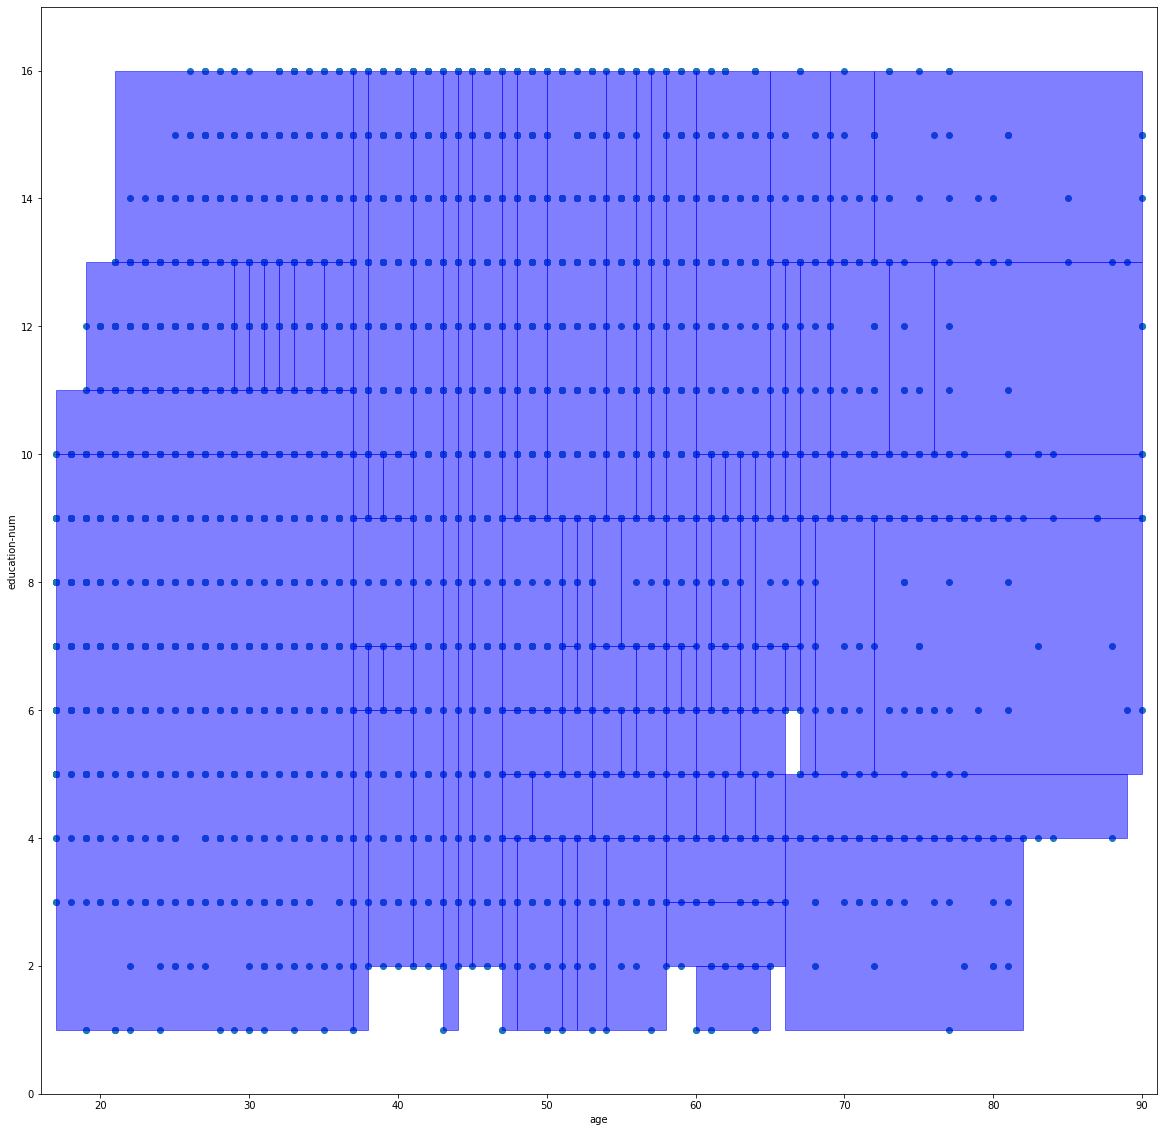

In [54]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, t_close_rects, column_x, column_y, edgecolor='b', facecolor='b')
pl.scatter(df[column_x], df[column_y])
pl.show()


In [64]:
#Entropy k-anonimity for Sensitive column
import numpy as np
from math import e
import pandas as pd 


def pandas_entropy(dfn, column, base=None):
    income_col = dfn[column]
    _, counts = np.unique(income_col, return_counts=True)
    probs = counts / counts.sum()
    entropy = -(probs * np.log(probs)).sum()

    if base:
        entropy = entropy / np.log(base)

    return entropy


In [62]:
entropy = pandas_entropy(dfn, 'income')


In [63]:
entropy

0.6507229430194343

In [73]:
#Entropy l-diverse for Sensitive column

def pandas_entropy(dfl, column, base=None):
    income_col = dfl[column]
    _, counts = np.unique(income_col, return_counts=True)
    probs = counts / counts.sum()
    entropy = -(probs * np.log(probs)).sum()

    if base:
        entropy = entropy / np.log(base)

    return entropy

In [74]:
entropy = pandas_entropy(dfl, 'income')
entropy

0.6931471805599453

In [97]:
#Entropy t-closeness for Sensitive column

def pandas_entropy(dft, column, base=None):
    income_col = dft[column]
    _, counts = np.unique(income_col, return_counts=True)
    probs = counts / counts.sum()
    entropy = -(probs * np.log(probs)).sum()

    if base:
        entropy = entropy / np.log(base)

    return entropy

entropy = pandas_entropy(dft, 'income')
entropy

0.6507229430194343

In [ ]:
"""
The above results shows that the best anomization is t-closeness
The best parameter was k=2,l=2 and p=5 
t-closeness model extends the l-diversity model by treating the values of an attribute distinctly by taking into account the distribution of data values for that attribute.

"""